## Introduction

This notebook will allow you to :
 - Read a .bag file and extract the color information, this information will be saved in a .mp4 video file that has the same name as the original file with a '_color.mp4' suffix
 
 - Read the .mp4 file and localize facial landmarks using FAN (I will add the option to used dlib in the future). The scrip will allow you to select if the face should be localized at:
  - First frame of the video (default)
  - All frames of the video
  - Every _n_ frame 

Landmarks and bounding box information will be stored in a .csv file that has the same name as the original file with a '_landmarks.csv' suffix
    
- Read the .bag file and extract the depth information. Extract the depth information for the landmark localized in the previous step and transform the landmarks from image coordinate frame into _real word_ coordinate frame (using the camera intrinsic parameters). _Real word_ landmarks position will be stored in  csv file that has the same name as the original file with a '_depth.csv' suffix
 

In [28]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [135]:
import pyrealsense2 as rs
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
import statsmodels.api as sm

In [76]:
BAG_File = r"C:\Users\GuarinD\Documents\GitHub\Extract_Color_Information\data\RM01_02_NSM_OPEN_20191101.bag"

### This portion of the notebook extract the color information 

In [77]:
# start the process of extracting the video information for each video
pipeline = rs.pipeline()
config = rs.config()

rs.config.enable_device_from_file(config, BAG_File, repeat_playback=False)

config.enable_all_streams()
profile = pipeline.start(config)

# create alignment object
align_to = rs.stream.color
align = rs.align(align_to)

# inform the device that this is not live streaming from camera
playback = profile.get_device().as_playback()
playback.set_real_time(False)
duration = playback.get_duration()

true_frame_number = []
frame_number = []
time_st = []

num_frame = 0


Color_Frames = []#{}

try:
    while True:
        frames = pipeline.wait_for_frames(100)  #get frame from file 
        
        this_frame = frames.get_frame_number()  #get frame number 
        
        if (num_frame != 0) and (true_frame_number[-1] == this_frame): #verify that frame number is not repeated 
            #if frame number is repeated then replace the stored information 
            aligned_frames = align.process(frames)

            #take color and depth from frame, if any to these is not available then skip the frame
            aligned_depth = aligned_frames.get_depth_frame()
            aligned_color = aligned_frames.get_color_frame()

            # validate that both frames are available
            if not aligned_depth or not aligned_color:
                continue

            time_stamp = frames.get_timestamp()
            true_frame_number[-1] = frames.get_frame_number()
            time_st[-1] = time_stamp 

            # transform to np array

            color_data = np.asanyarray(aligned_color.as_frame().get_data(), dtype=np.int)
            #depth_data = np.asanyarray(aligned_depth.as_frame().get_data(), dtype=np.int)
            # adjust depth data in meters
            #depth_data *= depth_scale

            Color_Frames[-1] = color_data
            
        else:
            #if frame number is not repeated then append the stored information 
            aligned_frames = align.process(frames)

            #take color and depth from frame, if any to these is not available then skip the frame
            aligned_depth = aligned_frames.get_depth_frame()
            aligned_color = aligned_frames.get_color_frame()

            # validate that both frames are available
            if not aligned_depth or not aligned_color:
                continue

            time_stamp = frames.get_timestamp()
            true_frame_number.append(frames.get_frame_number())
            time_st.append(time_stamp )

            # transform to np array

            color_data = np.asanyarray(aligned_color.as_frame().get_data(), dtype=np.int)
            #depth_data = np.asanyarray(aligned_depth.as_frame().get_data(), dtype=np.int)
            # adjust depth data in meters
            #depth_data *= depth_scale

            Color_Frames.append(color_data)
            #Depth_Frames.append(depth_data

            frame_number.append(num_frame)
            num_frame += 1
        
except RuntimeError:
    pass
finally:
    pipeline.stop()
    
duration_movie = duration.total_seconds()
FPS = num_frame/duration_movie
height, width,_ =  Color_Frames[0].shape

color_file = BAG_File[:-4]+'_color.mp4'

video = VideoWriter(color_file, -1, int(FPS), (width,height))

for k in range(num_frame):
    frame_to_save = Color_Frames[k].astype('uint8')
    video.write(frame_to_save)

video.release()    


cvs_frame_info = BAG_File[:-4]+'_frameInfoColor.csv'
df_cols = ['Actual_Frame_Number', 'Frame_Time_Stamp', 'Frame_Number_in_Video']
df = pd.DataFrame(columns=df_cols)
df['Actual_Frame_Number'] = true_frame_number
df['Frame_Time_Stamp'] = (np.array(time_st)-time_st[0])/1000
df['Frame_Number_in_Video'] = frame_number

df.to_csv(cvs_frame_info)
print('done')

done


### This portion of the notebook takes the color information and finds the position of facial landmarks using FAN

#### Load models for face and facial landmarks localization

In [78]:
from face_alignment.utils import *
from face_alignment import api as face_alignment
from face_alignment.models import FAN
from face_alignment.detection.sfd import sfd_detector

def load_weights(model, filename):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

face_alignment_model = r"./models/2DFAN4-11f355bf06.pth.tar"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#Face alignement
network_size = 4
face_alignment_net = FAN(network_size)
load_weights(face_alignment_net,face_alignment_model)
face_alignment_net.to(device)
face_alignment_net.eval()
#face detection 
face_detector_model = r"./models/s3fd-619a316812.pth"
face_detection_net = sfd_detector.SFDDetector(device=device, path_to_detector=face_detector_model, verbose=False)

In [79]:
localize_face = 0
# localize_face = 0 -> Face is localized at a single frame in the video (the middle frame)
# localize_face = -1 -> Face is localized at each frame of the video
# localize_face = n -> face is localized every n frames 

# we will start by localizing the face in the middel of the video, if additional information is needed 
# then will be added as required

video_handler = cv2.VideoCapture(color_file)  # read the video
num_frames = int(video_handler.get(cv2.CAP_PROP_FRAME_COUNT))
video_fps = int(video_handler.get(cv2.CAP_PROP_FPS))
video_handler.set(cv2.CAP_PROP_POS_FRAMES, num_frames//2)

success, image = video_handler.read()

if success: 
    detected_faces = face_detection_net.detect_from_image(image)
    for i, d in enumerate(detected_faces):
        center = torch.FloatTensor(
            [d[2] - (d[2] - d[0]) / 2.0, d[3] - (d[3] - d[1]) / 2.0])
        center[1] = center[1] - (d[3] - d[1]) * 0.12
        scale = (d[2] - d[0] + d[3] - d[1]) / face_detection_net.reference_scale
video_handler.release()

# at this point we have the position of the face in the mid frame. Let's use that info

In [80]:
#here you can modify the bounding box if needed. You probably will need to update the y2 coordinate
print(detected_faces)
#modify -- if you are doing this for open mouth protocols, then just add ~30 to 50 to the 4 element of the vector
detected_faces[0][3] = detected_faces[0][3]+40
print(detected_faces)
#update parameters with new bounding box

for i, d in enumerate(detected_faces):
    center = torch.FloatTensor(
        [d[2] - (d[2] - d[0]) / 2.0, d[3] - (d[3] - d[1]) / 2.0])
    center[1] = center[1] - (d[3] - d[1]) * 0.12
    scale = (d[2] - d[0] + d[3] - d[1]) / face_detection_net.reference_scale

[array([260.41446   ,  74.1201    , 425.92075   , 293.44287   ,
         0.99997354], dtype=float32)]
[array([260.41446   ,  74.1201    , 425.92075   , 333.44287   ,
         0.99997354], dtype=float32)]


In [81]:
#create a dataframe that will store all the information 
df_cols = ["BAG_Frame_number","Video_Frame_number", "bbox_top_x", "bbox_top_y", "bbox_bottom_x", "bbox_bottom_y"]
for i in range(0,68):
    num=str(i)
    xx = 'landmark_'+num+'_x'
    yy = 'landmark_'+num+'_y'
    df_cols.append(xx)
    df_cols.append(yy)
    
LandmarkDataFrame = pd.DataFrame(columns = df_cols)

# re-position the video handler at the first frame and start going frame by frame
video_handler = cv2.VideoCapture(color_file)  # read the video
k = 0
success = True
while success:
    success, image = video_handler.read()
    if success:
        
        if localize_face == 0:
            #do not localize the face, use previous info 
            pass 
        elif localize_face == -1 :
            #localize the face at each frame, upd
            update_detected_faces = face_detection_net.detect_from_image(image)
            for i, d in enumerate(update_detected_face):
                
                if d[4]>=0.8:
                    #do we trust the face localizer, if yes (>0.8) then update the bounding box, 
                    # if not (<0.8) don't update the bounding box
                    detected_faces = update_detected_face
                    center = torch.FloatTensor(
                        [d[2] - (d[2] - d[0]) / 2.0, d[3] - (d[3] - d[1]) / 2.0])
                    center[1] = center[1] - (d[3] - d[1]) * 0.12
                    scale = (d[2] - d[0] + d[3] - d[1]) / face_detection_net.reference_scale
                           
        else:
            #only update every n frames
            if (k+1)%localize_face == 0:
                update_detected_face = face_detection_net.detect_from_image(image)
                for i, d in enumerate(detected_faces):

                    if d[4]>=0.8:
                        #do we trust the face localizer, if yes (>0.8) then update the bounding box, 
                        # if not (<0.8) don't update the bounding box
                        detected_faces = update_detected_face
                        center = torch.FloatTensor(
                            [d[2] - (d[2] - d[0]) / 2.0, d[3] - (d[3] - d[1]) / 2.0])
                        center[1] = center[1] - (d[3] - d[1]) * 0.12
                        scale = (d[2] - d[0] + d[3] - d[1]) / face_detection_net.reference_scale
            
        
        inp = crop(image, center, scale)
        inp = torch.from_numpy(inp.transpose(
                    (2, 0, 1))).float()
        inp = inp.to(device)
        inp.div_(255).unsqueeze_(0)

        out = face_alignment_net(inp)[-1].detach() #[-1] is to get the output of the last hourglass block
        out = out.cpu()
        pts, pts_img = get_preds_fromhm(out, center, scale)
        
        pts_img = pts_img.view(68, 2)
        


        # Store everything in a dataframe
        datus = []
        datus.append(true_frame_number[int(k)])  #frame number provided by the .bag file 
        datus.append(int(k)+1)  # frame number in the color_only video 
    
        datus.append(detected_faces[0][0])  #top
        datus.append(detected_faces[0][1])  #left
        datus.append(detected_faces[0][2])  #bottom
        datus.append(detected_faces[0][3])  #right

        all_landmarks = pts_img.numpy()
        for x,y in all_landmarks:
            datus.append(x), datus.append(y)  #x and y position of each landmark

        LandmarkDataFrame = LandmarkDataFrame.append(pd.Series(datus,index = df_cols), 
                               ignore_index = True)
        
        k +=1 

        
#add time to landmarks 
LandmarkDataFrame.insert(loc=1, column='Time_Stamp (s)', value=(np.array(time_st)-time_st[0])/1000)
        
landmark_file = BAG_File[:-4]+'_landmarks.csv'
LandmarkDataFrame.to_csv(landmark_file)   



print('done')

done


### Smooth landmarks positions and generate a new video showing landmarks 

In [101]:
LandmarkDataFrame = pd.read_csv(BAG_File[:-4]+'_landmarks.csv', index_col=0)
b, a = signal.bessel(2,0.1)
windowlength=5
ARdegree=3
MAdegree=3
for i in range(68):
    num=str(i)
    xx = LandmarkDataFrame['landmark_'+num+'_x'].values
    xx_med = signal.medfilt(xx,kernel_size=windowlength)
#     mod_xx = sm.tsa.statespace.SARIMAX(xx, order=(ARdegree,0,MAdegree),seasonal_order=(0, 0, 0, 0),simple_differencing=True)
#     res_xx = mod_xx.fit()
#     predict_xx = res_xx.get_prediction(end=mod_xx.nobs +0-1)
#     predict_xx_out = predict_xx.predicted_mean
#     predict_xx_out[0] = xx[0]

    
    yy = LandmarkDataFrame['landmark_'+num+'_y'].values
    yy_med = signal.medfilt(yy,kernel_size=windowlength)  
#     mod_yy = sm.tsa.statespace.SARIMAX(yy, order=(ARdegree,0,MAdegree),seasonal_order=(0, 0, 0, 0),simple_differencing=True)
#     res_yy = mod_yy.fit()
#     predict_yy = res_yy.get_prediction(end=mod_yy.nobs +0-1)
#     predict_yy_out = predict_yy.predicted_mean
#     predict_yy_out[0] = yy[0]
       
    LandmarkDataFrame['landmark_'+num+'_x'] = xx_med
    LandmarkDataFrame['landmark_'+num+'_y'] = yy_med
    
landmark_file = BAG_File[:-4]+'_landmarksFiltered.csv'
LandmarkDataFrame.to_csv(landmark_file)    

color_file_landmark = BAG_File[:-4]+'_colorlandmark.mp4'

video = VideoWriter(color_file_landmark, -1, int(FPS), (width,height))
video_handler = cv2.VideoCapture(color_file)  # read the video
success = True 
k=0
for k in range(int(num_frames)):
    success, image = video_handler.read()

    frame_number=k+1
    frame_information = LandmarkDataFrame.loc[LandmarkDataFrame['Video_Frame_number'] == frame_number].values
    shape = np.array([frame_information[0][7:]])
    shape = np.reshape(shape.astype(np.int), (-1, 2))
    for (x, y) in shape:
        if x is np.NaN:
            continue
        else:
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

    frame_to_save = image
    video.write(frame_to_save)
    k +=1

video.release()

print('done -- please review video')

done -- please review video


### This portion of the notebook determines the deepth information for each landmark, it also transform the landmarks from pixel coordinates to real-word coordinates 

In [124]:
#load landmakrs information
DF_landmarks = pd.read_csv(BAG_File[:-4]+'_landmarksFiltered.csv', index_col=0)

#create dataframe to store information about 3d position of landmarks
df_cols_p1 = ["BAG_Frame_number","Video_Frame_number",]
for i in range(0,68):
    num=str(i)
    xx = 'landmark_'+num
    df_cols_p1.append(xx)
    df_cols_p1.append(xx)
    df_cols_p1.append(xx)
    
df_cols_p2 = ["",""]
for i in range(0,68):
    df_cols_p2.append("x")
    df_cols_p2.append("y")
    df_cols_p2.append("z")
    
header = [np.array(df_cols_p1), 
np.array(df_cols_p2)] 

DF_3dpositions= pd.DataFrame(columns = header)

# start the process of extracting the video information for each video
pipeline = rs.pipeline()
config = rs.config()

rs.config.enable_device_from_file(config, BAG_File, repeat_playback=False)

config.enable_all_streams()
profile = pipeline.start(config)

# create alignment object
align_to = rs.stream.color
align = rs.align(align_to)

# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()

# inform the device that this is not live streaming from camera
playback = profile.get_device().as_playback()
playback.set_real_time(False)
duration = playback.get_duration()

#fill holes in the depth information (based on this example: https://nbviewer.jupyter.org/github/IntelRealSense/librealsense/blob/jupyter/notebooks/depth_filters.ipynb)
spatial = rs.spatial_filter()
spatial.set_option(rs.option.filter_magnitude, 2)
spatial.set_option(rs.option.filter_smooth_alpha, 0.5)
spatial.set_option(rs.option.filter_smooth_delta, 20)
spatial.set_option(rs.option.holes_fill, 3)

true_frame_number = []
frame_number = []
time_st = []

num_frame = 0

try:
    while True:
        frames = pipeline.wait_for_frames(100)
        
        this_frame = frames.get_frame_number()  #get frame number
        
        #verify that we have landmarks for this particular frame 
        landmarks = DF_landmarks.loc[DF_landmarks['BAG_Frame_number'] == this_frame].values
        
        #if there are not landmakrs then just ignore the frame
        
        if len(landmarks)>0 : 
            #continue only if landmarks for the frame are avaliable
            landmarks = landmarks[0][7:]
            landmarks = landmarks.astype('float').reshape(-1, 2)
            
            if (num_frame != 0) and (true_frame_number[-1] == this_frame): #verify that frame number is not repeated 
                #frame is repeated
                aligned_frames = align.process(frames)
        
                #take color and depth from frame, if any to these is not available then skip the frame
                aligned_depth = aligned_frames.get_depth_frame()
                aligned_color = aligned_frames.get_color_frame()

                # validate that both frames are available
                if not aligned_depth or not aligned_color:
                    continue

                time_stamp = frames.get_timestamp()
                true_frame_number[-1] = frames.get_frame_number()
                time_st[-1] = time_stamp
                frame_number[-1] = num_frame

                # Intrinsics & Extrinsics
                depth_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                color_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                depth_to_color_extrin = aligned_depth.profile.get_extrinsics_to(aligned_color.profile)

                aligned_filtered_depth = spatial.process(aligned_depth)
                depth_frame_array = np.asanyarray(aligned_filtered_depth.get_data())
                depth_frame_array = depth_frame_array*depth_scale

                coords = []
                coords.append(frames.get_frame_number())
                coords.append(int(num_frame)+1)

                for (c,r) in landmarks:  #landmarks provide the x,y position of each landmark. x are columns and y are rows in the figure
                    #depth_value = depth_frame.get_distance(int(c),int(r))
                    #x,y,z = rs.rs2_deproject_pixel_to_point(depth_intrin, [int(c), int(r)], depth_value)
                    depth_value = depth_frame_array[int(r),int(c)]
                    z = depth_value
                    x = z*((c-depth_intrin.ppx)/depth_intrin.fx)
                    y = z*((r-depth_intrin.ppy)/depth_intrin.fy)                    
                    coords.append(x),coords.append(y),coords.append(z)

                #DF_3dpositions = DF_3dpositions.append(pd.Series(coords,index = header), ignore_index = True)
                DF_3dpositions.iloc[-1] =  pd.Series(coords,index = header)
            else:
                aligned_frames = align.process(frames)
        
                #take color and depth from frame, if any to these is not available then skip the frame
                aligned_depth = aligned_frames.get_depth_frame()
                aligned_color = aligned_frames.get_color_frame()

                # validate that both frames are available
                if not aligned_depth or not aligned_color:
                    continue

                time_stamp = frames.get_timestamp()
                true_frame_number.append(frames.get_frame_number())
                time_st.append(time_stamp)
                frame_number.append(num_frame)

                # Intrinsics & Extrinsics
                depth_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                color_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                depth_to_color_extrin = aligned_depth.profile.get_extrinsics_to(aligned_color.profile)

                aligned_filtered_depth = spatial.process(aligned_depth)
                depth_frame_array = np.asanyarray(aligned_filtered_depth.as_frame().get_data())
                depth_frame_array = depth_frame_array*depth_scale

                coords = []
                coords.append(frames.get_frame_number())
                coords.append(int(num_frame)+1)

                for (c,r) in landmarks:  #landmarks provide the x,y position of each landmark. x are columns and y are rows in the figure
                    #depth_value = depth_frame.get_distance(int(c),int(r))
                    #x,y,z = rs.rs2_deproject_pixel_to_point(depth_intrin, [int(c), int(r)], depth_value)
                    depth_value = depth_frame_array[int(r),int(c)]
                    z = depth_value
                    x = z*((c-depth_intrin.ppx)/depth_intrin.fx)
                    y = z*((r-depth_intrin.ppy)/depth_intrin.fy)                    
                    coords.append(x),coords.append(y),coords.append(z)

                DF_3dpositions = DF_3dpositions.append(pd.Series(coords,index = header), ignore_index = True)

                num_frame += 1

except RuntimeError:
    pass
finally:
    pipeline.stop()
    
    
#add time to 3d coordinates
DF_3dpositions.insert(loc=1, column='Time_Stamp (s)', value=(np.array(time_st)-time_st[0])/1000)
landmarks_3D_file = BAG_File[:-4]+'_Landmarks3D.csv'
DF_3dpositions.to_csv(landmarks_3D_file)
    
cvs_frame_info = BAG_File[:-4]+'_frameInfoDepth.csv'
DF = pd.DataFrame()
DF['Actual_Frame_Number'] = true_frame_number
DF['Frame_Time_Stamp'] = (np.array(time_st)-time_st[0])/1000
DF['Frame_Number_in_Video'] = frame_number
DF.to_csv(cvs_frame_info)



print('done')

done


## Visualization 

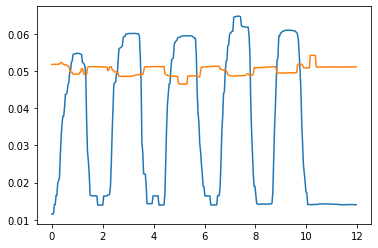

In [131]:
DF_3dpositions = pd.read_csv(BAG_File[:-4]+'_Landmarks3D.csv')
#DF_3dpositions = pd.read_csv('./data/RM02_02_RST_REST_Landmarks3D.csv')


#we are goinf to focus on the rihgt and left corners of the mouth and the top and bottom lips 
#these positions correspond to landmarks 48, 54 and 51, 57 respectivelly

Right_corner = DF_3dpositions.filter(like='landmark_48')
Right_corner_x = Right_corner.iloc[1:,[0]].values
Right_corner_y = Right_corner.iloc[1:,[1]].values
Right_corner_z = Right_corner.iloc[1:,[2]].values
Right_Corner_Coord = np.column_stack((Right_corner_x.astype(np.double),Right_corner_y.astype(np.double),Right_corner_z.astype(np.double)))

Left_corner = DF_3dpositions.filter(like='landmark_54')
Left_corner_x = Left_corner.iloc[1:,[0]].values
Left_corner_y = Left_corner.iloc[1:,[1]].values
Left_corner_z = Left_corner.iloc[1:,[2]].values
Left_Corner_Coord = np.column_stack((Left_corner_x.astype(np.double),Left_corner_y.astype(np.double),Left_corner_z.astype(np.double)))

Top_lip = DF_3dpositions.filter(like='landmark_51')
Top_lip_x = Top_lip.iloc[1:,[0]].values
Top_lip_y = Top_lip.iloc[1:,[1]].values
Top_lip_z = Top_lip.iloc[1:,[2]].values
Top_Lip_Coord = np.column_stack((Top_lip_x.astype(np.double),Top_lip_y.astype(np.double),Top_lip_z.astype(np.double)))

Bottom_lip = DF_3dpositions.filter(like='landmark_57')
Bottom_lip_x = Bottom_lip.iloc[1:,[0]].values
Bottom_lip_y = Bottom_lip.iloc[1:,[1]].values
Bottom_lip_z = Bottom_lip.iloc[1:,[2]].values
Bottom_Lip_Coord = np.column_stack((Bottom_lip_x.astype(np.double),Bottom_lip_y.astype(np.double),Bottom_lip_z.astype(np.double)))


mouth_corners = np.zeros((len(Right_Corner_Coord),1))
top_bottom = np.zeros((len(Right_Corner_Coord),1))
for i in range(len(Right_Corner_Coord)):
    mouth_corners[i] = np.sqrt((Right_Corner_Coord[i,0]-Left_Corner_Coord[i,0])**2+(Right_Corner_Coord[i,1]-Left_Corner_Coord[i,1])**2+(Right_Corner_Coord[i,2]-Left_Corner_Coord[i,2])**2)
    top_bottom[i] = np.sqrt((Top_Lip_Coord[i,0]-Bottom_Lip_Coord[i,0])**2+(Top_Lip_Coord[i,1]-Bottom_Lip_Coord[i,1])**2+(Top_Lip_Coord[i,2]-Bottom_Lip_Coord[i,2])**2)
    
    
time_sec = DF_3dpositions['Time_Stamp (s)'].values[1:]
plt.plot(time_sec,signal.medfilt(top_bottom[:,0],kernel_size=11))
plt.plot(time_sec,signal.medfilt(mouth_corners[:,0],kernel_size=11))


In [152]:
out = pd.DataFrame()
out['Video_frame'] = frame_number
out['Frame_Time_Stamp'] = (np.array(time_st)-time_st[0])/1000
out['Horiz_Lip_Motion'] = signal.medfilt(top_bottom[:,0],kernel_size=11)
out['Vert_Lip_Motion'] = signal.medfilt(mouth_corners[:,0],kernel_size=11)
cvs_frame_info = BAG_File[:-4]+'_FinalResults.csv'
out.to_csv('./resutls/'+cvs_frame_info)

OSError: [Errno 22] Invalid argument: './resutls/C:\\Users\\GuarinD\\Documents\\GitHub\\Extract_Color_Information\\data\\RM01_02_NSM_OPEN_20191101_FinalResults.csv'

In [105]:
depth_scale

0.00012498664727900177

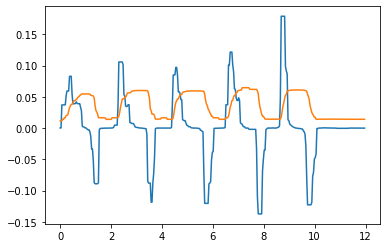

In [151]:
smooth_signal = signal.medfilt(top_bottom[:,0],kernel_size=11)
plt.plot(time_sec,signal.medfilt(np.gradient(smooth_signal, time_sec),9))
plt.plot(time_sec,signal.medfilt(top_bottom[:,0],kernel_size=11))

In [148]:
vel_signal = signal.medfilt(np.gradient(smooth_signal, time_sec),9)
peaks_pos, _ = signal.find_peaks(vel_signal, height=0.05)
peaks_neg, _ = signal.find_peaks(-vel_signal, height=0.05)

In [149]:
peaks_pos, peaks_neg

(array([ 12,  71, 136, 201, 262], dtype=int64),
 array([ 42, 107, 172, 235, 293], dtype=int64))